<a href="https://colab.research.google.com/github/HanqiLouis/IPEO_Project2024/blob/main/UNET_Pixel_wise_Seg_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Try 1: Pixel-wise segmentation using U-NET
Idea: Create a groundtruth mask for each image and train with U-NET.

## Steup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install dependencies
import sys
!{sys.executable} -m pip install torch torchvision
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tqdm

In [2]:
# Check GPU
import torch
print(torch.cuda.is_available())

True


In [3]:
# Manual set seed
seed = 363636
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
# Google Drive path to dataset folder
data_root = '/content/drive/MyDrive/IPEO/Project/LargeRocksDetectionDataset'     # Please replace with your own path to epfl_road-segmentation folder

## Data preprocessing and visualization

In [6]:
# JSON file

import json
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tifffile
import os

json_file_path = os.path.join(data_root, 'large_rock_dataset.json')

# Load the JSON file
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)
print('Genreal information about the data:', data['info'])
dataset = data['dataset']
print('Number of samples:', len(dataset))
sample_info = dataset[10]
print('Looking at the first images:', sample_info['file_name'])
print('Looking at rocks annotations for the firsdt images:\n', sample_info['rocks_annotations'][0])

Genreal information about the data: {'description': 'Large Rocks Detection Dataset ', 'version': '1.0', 'year': 2024, 'contributor': 'Valerie Zermatten', 'date_created': '2024/09/30'}
Number of samples: 992
Looking at the first images: 2581_1126_2_2.tif
Looking at rocks annotations for the firsdt images:
 {'rock_id': 1459.0, 'abs_rock_coordinates': [2581767.93, 1126509.48], 'pixel_within_patch_coordinates': [608.0, 51.0], 'relative_within_patch_location': [0.95, 0.08]}


Rocks 1 Coordinates: (96.0, 467.0)
Rocks 2 Coordinates: (51.0, 160.0)
Rocks 3 Coordinates: (77.0, 179.0)
Rocks 4 Coordinates: (198.0, 77.0)
Rocks 5 Coordinates: (582.0, 0.0)


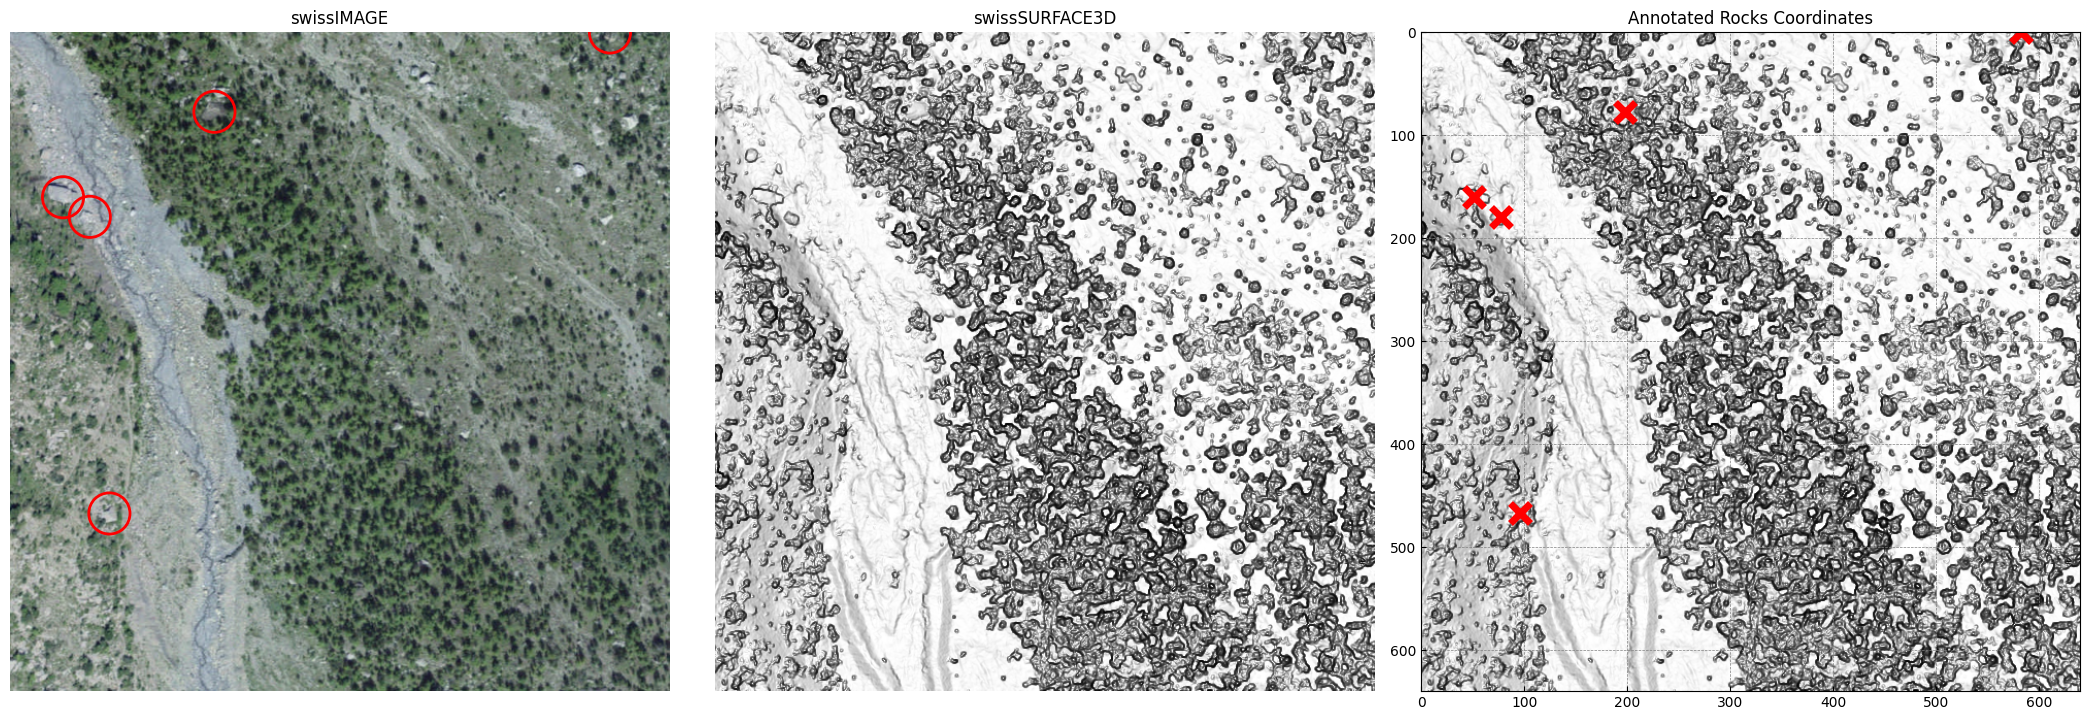

In [10]:
# Visualize some images

import os
import tifffile
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming data, data_root, and sample_info are already defined
dataset = data['dataset']
idx = np.random.randint(0, len(dataset))

src_SI = os.path.join(data_root, 'swissImage_50cm_patches', dataset[idx]['file_name'])
src_HS = os.path.join(data_root, 'swissSURFACE3D_hillshade_patches', dataset[idx]['file_name'])

bboxes = dataset[idx]['rocks_annotations']  # Bounding boxes

# Load the swissIMAGE and swissSURFACE3D images
image = tifffile.imread(src_SI)
dsm = tifffile.imread(src_HS)

# Create a figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(21, 7))

# Plot swissIMAGE
ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('swissIMAGE')

# Add rocks annotations (red circles) to swissIMAGE
for box in bboxes:
    x, y = box['pixel_within_patch_coordinates']
    circ = patches.Circle((x, y), radius=20, linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(circ)

# Plot swissSURFACE3D
ax[1].imshow(dsm, cmap='gist_gray')
ax[1].axis('off')
ax[1].set_title('swissSURFACE3D')

# For the third plot, use the same background as swissSURFACE3D
ax[2].imshow(dsm, cmap='gist_gray')  # Use the DSM as the background
ax[2].set_title('Annotated Rocks Coordinates')
ax[2].grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)  # Add grid
ax[2].tick_params(axis='both', which='both', direction='in')  # Add tick marks

# Add rock coordinates as red 'X' markers on the third plot
i = 0
for box in bboxes:
    x, y = box['pixel_within_patch_coordinates']
    ax[2].plot(x, y, marker='x', markersize=15, color='red', linestyle='None', markeredgewidth=5)
    print(f'Rocks {i+1} Coordinates:', (x, y))
    i += 1

if i == 0:
    print('No rocks found')
# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# To delete already created groundtruth masks if needed

import os

# Path to the folder
folder_path = os.path.join(data_root, 'groundtruth')

# Delete all files in the folder
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")

print("All files deleted from the folder.")

In [ ]:
# Create and save groundtruth masks

import os
from PIL import Image, ImageDraw
output_folder = os.path.join(data_root, 'groundtruth')  # Folder to save generated masks

# Ensure output folder exists
os.makedirs(output_folder, exist_ok=True)

json_file_path = os.path.join(data_root, 'large_rock_dataset.json')

# Load the JSON file
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)
print('Genreal information about the data:', data['info'])
dataset = data['dataset']
print('Number of samples:', len(dataset))
for sample in range(len(dataset)):
  file_name = dataset[sample]['file_name']
  print(file_name)
  mask = Image.new("L", (640, 640), 0)  # 'L' mode for grayscale
  draw = ImageDraw.Draw(mask)
  radius = 15
  bboxes = dataset[sample]['rocks_annotations']
  for box in bboxes:
    x, y = box['pixel_within_patch_coordinates']
    draw.ellipse([(x - radius, y - radius), (x + radius, y + radius)], fill=255)

  # Save the mask with the same name as the image
  mask_path = os.path.join(output_folder, file_name)
  mask.save(mask_path)
  print(f"Saved mask for {file_name}.")

print("All masks generated and saved in the groundtruth folder.")

In [ ]:
# Compute the image means and stds

# Initialize variables for each channel
pixel_sum = np.zeros(3)
pixel_square_sum = np.zeros(3)
total_pixels = 0

image_folder = os.path.join(data_root, 'swissImage_50cm_patches')
# Loop through all images
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]

    # Accumulate sums for each channel
    pixel_sum += image_array.sum(axis=(0, 1))
    pixel_square_sum += (image_array ** 2).sum(axis=(0, 1))
    total_pixels += image_array.shape[0] * image_array.shape[1]

# Calculate mean and std for each channel
mean = pixel_sum / total_pixels
std = np.sqrt((pixel_square_sum / total_pixels) - (mean ** 2))

print(f"Dataset Mean (R, G, B): {mean}")
print(f"Dataset Std (R, G, B): {std}")

In [ ]:
# Compute the dsm mean and std

import os
import numpy as np
from PIL import Image

# Path to your dataset
dsm_folder = os.path.join(data_root, 'swissSURFACE3D_hillshade_patches')

# Initialize variables to compute mean and std
pixel_sum = 0
pixel_square_sum = 0
total_pixels = 0

# Loop through all images in the folder
for image_name in os.listdir(dsm_folder):
    image_path = os.path.join(dsm_folder, image_name)
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image_array = np.array(image, dtype=np.float32)  # Convert to float

    # Accumulate sums
    pixel_sum += image_array.sum()
    pixel_square_sum += (image_array ** 2).sum()
    total_pixels += image_array.size

# Calculate mean and standard deviation
mean = pixel_sum / total_pixels
std = np.sqrt((pixel_square_sum / total_pixels) - (mean ** 2))

print(f"Dataset dsm Mean: {mean}")
print(f"Dataset dsm Std: {std}")

## Dataloader
(No data augmentation applied)

In [16]:
import os
from torch.utils.data import dataset
from torch.utils.data import DataLoader
#from torchvision.transforms.functional import (to_tensor, normalize, resize, hflip, vflip, rotate)
import numpy as np
from PIL import Image
import torchvision.transforms as T

# Constants for normalizing image values (computed with previous cells)
IMAGE_MEANS = ((0.46979354, 0.49623052, 0.42854241), (197.18306657360446))
IMAGE_STDS = ((0.20187592, 0.19042274, 0.18708934), (54.99748124113858))

class LargeRocksDetectionDataset(dataset.Dataset):
    '''
        Custom Dataset class that loads images and ground truth segmentation
        masks from a directory.
    '''

    # Label class descriptions
    LABEL_CLASSES = ('Not Rock', 'Rock')

    def __init__(self, data_root, file_list=None):
        '''
            Dataset class constructor.

            Args:
                data_root (str): Root directory containing the images and ground truth folders.
                transform (callable, optional): Transformations to apply to images and groundtruth masks.
                file_list (list, optional): List of specific files from the dataset.
        '''
        super().__init__()

        self.data_root = data_root

        if file_list is not None:
            # Use provided file list
            self.data = file_list
        else:
            # Automatically gather all PNG files from the images folder
            imgs_folder = os.path.join(self.data_root, 'swissImage_50cm_patches')
            self.data = [f for f in os.listdir(imgs_folder) if f.endswith('.tif')]

    def __len__(self):
        '''
        Returns:
            int: Number of samples in the dataset.
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
        Loads and prepares images and corresponding labels (segmentation masks).

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Transformed image and its corresponding mask.
        '''
        item = self.data[idx]

        # Load the image
        image_path = os.path.join(self.data_root, 'swissImage_50cm_patches', item)
        image = Image.open(image_path)

        # Load the dsm file
        dsm_path = os.path.join(self.data_root, 'swissSURFACE3D_hillshade_patches', item)
        dsm = Image.open(dsm_path)

        # Default processing when no transformation is provided
        image = np.array(image, dtype=np.float32)
        image = (image - IMAGE_MEANS[0]) / IMAGE_STDS[0]
        dsm = np.array(dsm, dtype=np.float32)
        dsm = (dsm - IMAGE_MEANS[1]) / IMAGE_STDS[1]
        image = T.ToTensor()(image)
        dsm = T.ToTensor()(dsm)
        inputs = torch.cat([image,dsm], dim=0).float()

        # Load the segmentation mask (ground truth)
        mask_path = os.path.join(self.data_root, 'groundtruth', item)
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale
        mask = np.array(mask, dtype=np.int64)  # Convert mask to NumPy array
        # Map pixel values to binary labels (0 for background, 1 for road)
        white_threshold = 10  # Threshold to distinguish road vs. non-road pixels
        mask = np.where(mask > white_threshold, 1, 0)
        mask = torch.from_numpy(mask).long()  # Convert mask to tensor

        return inputs, mask


# DataLoader function
def load_dataloader(data_root, batch_size, split='training', file_list=None):
    '''
    Creates a DataLoader for the RoadSegmentationDataset.

    Args:
        data_root (str): Root directory of the dataset.
        batch_size (int): Number of samples per batch.
        split (str): Split type ('training' or 'validation'). Defaults to 'training'.
        file_list (list, optional): Specific file list to load.
        transform (callable, optional): Transformation function for the dataset.

    Returns:
        torch.utils.data.DataLoader: DataLoader object for the specified dataset split.
    '''
    dataset = LargeRocksDetectionDataset(
        data_root,  # Path to training folder
        file_list=file_list
    )
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(split == 'training'),  # Shuffle only for training split
        num_workers=2  # Use two CPU threads for loading data
    )

In [14]:
# Split into train, val, test sets

import os
import random

# List all image files in the training directory
image_files = sorted([f for f in os.listdir(os.path.join(data_root, 'swissImage_50cm_patches')) if f.endswith(".tif")])
dsm_files = sorted([f for f in os.listdir(os.path.join(data_root, 'swissSURFACE3D_hillshade_patches')) if f.endswith(".tif")])
groundtruth_files = sorted([f for f in os.listdir(os.path.join(data_root, 'groundtruth')) if f.endswith(".tif")])

# Ensure the same filenames exist in both directories
assert len(image_files) == len(dsm_files) == len(groundtruth_files), "Mismatch between image and groundtruth files."
assert all(img == dsm == gt for img, dsm, gt in zip(image_files, dsm_files, groundtruth_files)), "Image and groundtruth filenames do not match."

# Dataset splitting
random.seed(60)
random.shuffle(image_files)

train_split = int(0.70 * len(image_files))  # 70% of the dataset for training
val_split = int(0.20 * len(image_files))  # 20% for validation and the rest 10% for testing

# Save the images into different sets
data_splits = {
    'train': image_files[:train_split],
    'val': image_files[train_split:train_split + val_split],
    'test': image_files[train_split + val_split:],
}

print("Nb train:", len(data_splits['train']), "Nb val:", len(data_splits['val']), "Nb test:", len(data_splits['test']))

Nb train: 694 Nb val: 198 Nb test: 100


## Visualization of some images and groundtruth masks

Image tensor size: torch.Size([4, 640, 640])
Label tensor size: torch.Size([640, 640])


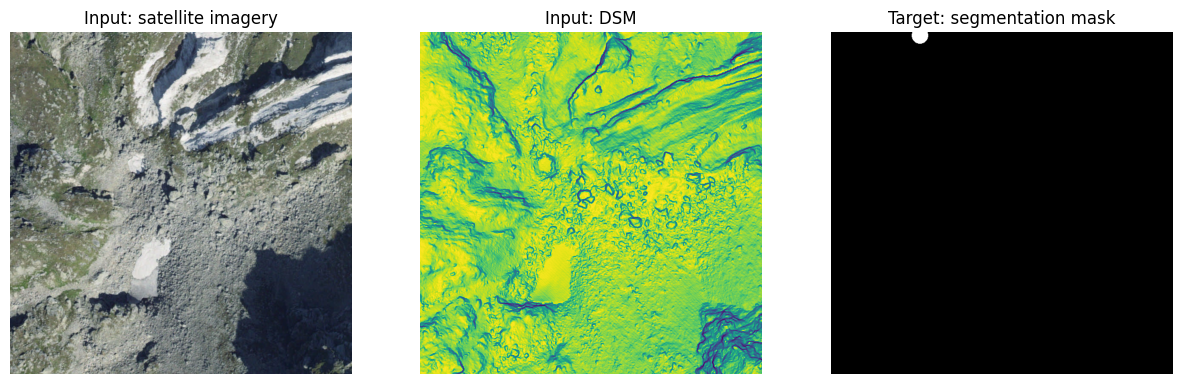

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialize train set images
dataset_train = LargeRocksDetectionDataset(data_root, file_list=data_splits['train'])

# draw a random sample
idx = torch.randint(0, len(dataset_train), (1,))
data, target = dataset_train.__getitem__(idx)
# Apply transformations

print(f'Image tensor size: {data.size()}')
print(f'Label tensor size: {target.shape}')

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Input image
# Unnormalize the image
unnormalized_data = data[:3,...] * torch.tensor(IMAGE_STDS[0]).view(-1, 1, 1) + torch.tensor(IMAGE_MEANS[0]).view(-1, 1, 1)
axes[0].imshow(np.array(unnormalized_data.permute(1, 2, 0), dtype=np.uint8))
axes[0].set_title('Input: satellite imagery')
axes[0].axis('off')

# Dsm (normalized)
axes[1].imshow(data[3,...].squeeze().numpy())
axes[1].set_title('Input: DSM')
axes[1].axis('off')

# Groundtruth mask
axes[2].imshow(target.squeeze().numpy(), cmap='gray')
axes[2].set_title('Target: segmentation mask')
axes[2].axis('off')

plt.show()

## Model training with U-NET

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling (Encoder)
        self.encoder1 = self.conv_block(4, 64, dropout_rate=0.1)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = self.conv_block(64, 128, dropout_rate=0.2)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = self.conv_block(128, 256, dropout_rate=0.2)
        self.pool3 = nn.MaxPool2d(2)

        self.encoder4 = self.conv_block(256, 512, dropout_rate=0.3)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024, dropout_rate=0.4)

        # Upsampling (Decoder)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512, dropout_rate=0.3)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256, dropout_rate=0.2)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128, dropout_rate=0.2)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64, dropout_rate=0.1)

        # Final output
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels, dropout_rate=0.0):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout_rate) if dropout_rate > 0 else nn.Identity(),
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)  # Skip connection
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.final(dec1)

In [21]:
# Test the model

dataloader_train = load_dataloader(data_root, batch_size=2, split='training')
model = UNet()

data, _ = iter(dataloader_train).__next__()
pred = model(data)

# Binary outputs
assert pred.size(1) == len(dataset_train.LABEL_CLASSES)-1, f'ERROR: invalid number of model output channels (should be # classes {len(dataset_train.LABEL_CLASSES)}, got {pred.size(1)})'
# Spatial alignment
assert pred.size(2) == data.size(2), f'ERROR: invalid spatial height of model output (should be {data.size(2)}, got {pred.size(2)})'
assert pred.size(3) == data.size(3), f'ERROR: invalid spatial width of model output (should be {data.size(3)}, got {pred.size(3)})'

In [22]:
#TODO
criterion = nn.BCEWithLogitsLoss()  # for binary classification

In [23]:
from torch.optim import Adam

def setup_optimiser(model, learning_rate, weight_decay):
    return Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

In [24]:
# Validation metrics Intersection of Union

def compute_iou(pred, target, threshold=0.5):
    """
    Compute Intersection over Union (IoU) score.

    Args:
        pred (torch.Tensor): Model output logits.
        target (torch.Tensor): Ground truth binary mask.
        threshold (float): Threshold for converting logits to binary predictions.

    Returns:
        float: IoU score.
    """
    # Convert logits to binary
    pred = (torch.sigmoid(pred) > threshold).float()

    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = (pred + target).clamp(0, 1).sum(dim=(1, 2, 3))

    iou = (intersection / (union + 1e-6)).mean().item()  # Avoid division by zero

    return iou

In [25]:
from tqdm.notebook import trange  # pretty progress bar
from sklearn.metrics import f1_score

def train_epoch(data_loader, model, optimiser, device):
    """
    Perform a single training epoch.

    Args:
        data_loader (DataLoader): DataLoader for the training data.
        model (torch.nn.Module): Model to train.
        optimiser (torch.optim.Optimizer): Optimizer for parameter updates.
        criterion (torch.nn.Module): Loss function (e.g., BCEWithLogitsLoss).
        device (torch.device): Device to use (CPU or GPU).

    Returns:
        tuple: Updated model, average loss, overall accuracy, and F1 score.
    """

    # Set model to training mode
    model.train(True)
    model.to(device)

    # Initialize statistics
    loss_total = 0.0
    oa_total = 0.0
    f1_total = 0.0

    # Progress bar
    pBar = trange(len(data_loader))

    for idx, (data, target) in enumerate(data_loader):
        # Move data and target to the specified device
        data, target = data.to(device), target.to(device)

        # Reset gradients
        optimiser.zero_grad()

        # Forward pass
        pred = model(data)  # Logits output

        # Adjust target dimensions and type
        target = target.unsqueeze(1).float()

        # Loss computation
        loss = criterion(pred, target)  # BCEWithLogitsLoss

        # Backward pass and optimizer step
        loss.backward()
        optimiser.step()

        # Update loss total
        loss_total += loss.item()

        # Compute metrics
        with torch.no_grad():
            # Convert logits to probabilities and apply threshold
            yhat = (torch.sigmoid(pred) > 0.5).float()

            # Compute overall accuracy
            oa_total += torch.mean((yhat == target).float()).item()

            # Compute F1 score (IoU)
            iou = compute_iou(pred, target)
            f1_total += iou


        # Update progress bar
        pBar.set_description(
            'Loss: {:.4f}, OA: {:.2f}%, F1: {:.2f}'.format(
                loss_total / (idx + 1),
                100 * oa_total / (idx + 1),
                f1_total / (idx + 1)
            )
        )
        pBar.update(1)

    pBar.close()

    # Normalize stats
    loss_total /= len(data_loader)
    oa_total /= len(data_loader)
    f1_total /= len(data_loader)

    return model, loss_total, oa_total, f1_total

In [26]:
def validate_epoch(data_loader, model, device):  # note: no optimizer needed
    """
    Perform one epoch of validation for a given model on a dataset.

    Args:
        data_loader (DataLoader): PyTorch DataLoader for the validation dataset.
        model (nn.Module): The model to validate.
        device (torch.device): The device to run validation on (e.g., 'cuda' or 'cpu').

    Returns:
        loss_total (float): Average loss across the validation dataset.
        oa_total (float): Average overall accuracy across the validation dataset.
        f1_total (float): Average F1 score (IoU) across the validation dataset.
    """

    # Set model to evaluation mode to disable dropout/batch norm updates
    model.eval()
    model.to(device)

    # Initialize accumulators for loss, overall accuracy (OA), and F1 score (IoU)
    loss_total = 0.0
    oa_total = 0.0
    f1_total = 0.0

    # Progress bar setup for dataset iteration
    pBar = trange(len(data_loader))

    # Iterate over the validation DataLoader
    for idx, (data, target) in enumerate(data_loader):
        with torch.no_grad():  # Disable gradient computation for validation

            # Move data and target tensors to the correct device
            data, target = data.to(device), target.to(device)

            # Forward pass: compute predictions
            pred = model(data)

            # Adjust target tensor dimensions to match `pred`
            target = target.unsqueeze(1).float()

            # Compute the loss
            loss = criterion(pred, target)

            # Update loss accumulator
            loss_total += loss.item()

            # Convert predictions to binary
            yhat = (torch.sigmoid(pred) > 0.5).float()

            # Compute overall accuracy (OA)
            oa_total += torch.mean((yhat == target).float()).item()

            # Compute IoU
            iou = compute_iou(pred, target)
            f1_total += iou

            # Update the progress bar with current loss and accuracy
            pBar.set_description('Loss: {:.2f}, OA: {:.2f}'.format(
                loss_total/(idx+1),  # Average loss so far
                100 * oa_total/(idx+1)  # Average OA so far, formatted as a percentage
            ))
            pBar.update(1)  # Move progress bar forward

    pBar.close()

    # Normalize accumulated stats by the number of batches
    loss_total /= len(data_loader)
    oa_total /= len(data_loader)
    f1_total /= len(data_loader)

    return loss_total, oa_total, f1_total

In [27]:
# Store the states of the CNN during training

import glob

os.makedirs('cnn_states/UNet', exist_ok=True)  # Create directory for saving model states if it doesn't exist

def load_model(epoch='latest'):
    """
    Load the model state from a saved file. Defaults to loading the latest saved epoch.

    Args:
        epoch (str or int): 'latest' to load the most recent model or a specific epoch number.

    Returns:
        model (torch.nn.Module): The UNet model with loaded state.
        epoch (int): The epoch number of the loaded state. Returns 0 if no saved state exists.
    """

    # Initialize a new UNet model
    model = UNet()

    # Get the list of all saved model state files in the directory
    modelStates = glob.glob('cnn_states/UNet/*.pth')

    # Check if there are any saved states and if the specified epoch is valid
    if len(modelStates) and (epoch == 'latest' or epoch > 0):

        # Extract epoch numbers from the filenames
        modelStates = [int(m.replace('cnn_states/UNet/','').replace('.pth', '')) for m in modelStates]

        # If 'latest' is specified, determine the most recent epoch
        if epoch == 'latest':
            epoch = max(modelStates)

        # Load the state dictionary for the specified epoch
        stateDict = torch.load(open(f'cnn_states/UNet/{epoch}.pth', 'rb'), map_location='cpu')
        model.load_state_dict(stateDict)  # Load the state into the model
    else:
        # No saved states found; return a fresh model
        epoch = 0

    return model, epoch


def save_model(model, epoch):
    """
    Save the current state of the model to a file, using the epoch number in the filename.

    Args:
        model (torch.nn.Module): The model to save.
        epoch (int): The epoch number, which is included in the filename.
    """
    # Save the model's state dictionary to the specified file
    torch.save(model.state_dict(), open(f'cnn_states/UNet/{epoch}.pth', 'wb'))

## Training test to evaluate if it works

In [29]:
from torch.optim.lr_scheduler import StepLR

# Define hyperparameters
device = 'cuda'
#device = 'cpu'        # set device to CPU if no GPU is available
start_epoch = 0        # set to 0 to start from scratch again or to 'latest' to continue training from saved checkpoint
batch_size = 16
learning_rate = 0.001
weight_decay = 0.001
num_epochs = 50

# Initialise data loaders
dl_train = load_dataloader(data_root, batch_size, 'training', file_list=data_splits['train'])  # train dataloader
dl_val = load_dataloader(data_root, batch_size, 'validation', file_list=data_splits['val']) # validation dataloader

# Load model
model, epoch = load_model(epoch=start_epoch)
model = model.to(device)
optim = setup_optimiser(model, learning_rate, weight_decay)
scheduler = StepLR(optim, step_size=25, gamma=0.7)  # Reduce LR by a factor of 0.7 every 25 epochs

# Lists to store all metrics during training
loss_training = []
oa_training = []
f1_training = []
loss_validation = []
oa_validation = []
f1_validation = []

# Do epochs
while epoch < num_epochs:

  # Training
  model, loss_train, oa_train, f1_train = train_epoch(dl_train, model, optim, device)

  # Validation
  loss_val, oa_val, f1_val = validate_epoch(dl_val, model, device)

  print(f'[Ep. {epoch+1}/{num_epochs}] '
        f'Loss train: {loss_train:.2f}, val: {loss_val:.2f}; '
        f'OA train: {100*oa_train:.2f}, val: {100*oa_val:.2f}; '
        f'F1 train: {f1_train:.2f}, val: {f1_val:.2f}')

  # Add the calculated metrics in the corresponding lists
  loss_training.append(loss_train)
  oa_training.append(oa_train)
  f1_training.append(f1_train)
  loss_validation.append(loss_val)
  oa_validation.append(oa_val)
  f1_validation.append(f1_val)

  scheduler.step()  # Update learning rate
  epoch += 1
  # Save model
  save_model(model, epoch)

  0%|          | 0/22 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.12 GiB. GPU 0 has a total capacity of 14.75 GiB of which 289.06 MiB is free. Process 3605 has 14.46 GiB memory in use. Of the allocated memory 14.35 GiB is allocated by PyTorch, and 527.00 KiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
%matplotlib inline

def visualize(dataLoader, epochs, numImages=5):
    """
    Visualize predictions from models at specified epochs on a dataset.

    Args:
        dataLoader: DataLoader object for the dataset to visualize.
        epochs: List of epochs for which to load and visualize model predictions.
        numImages: Number of images to visualize from the DataLoader.
    """
    # Load models for the specified epochs
    models = [load_model(e)[0] for e in epochs]
    numModels = len(models)

    # Loop through the dataset to visualize a specific number of images
    for idx, (data, labels) in enumerate(dataLoader):
        if idx == numImages:  # Stop after visualizing the specified number of images
            break

        # Create subplots for original image, groundtruth, and predictions
        _, ax = plt.subplots(nrows=1, ncols=numModels + 2, figsize=(20, 15))

        # Unnormalize the input image for display
        unnormalized_data = data * torch.tensor(IMAGE_STDS[0]).view(-1, 1, 1) + torch.tensor(IMAGE_MEANS[0]).view(-1, 1, 1)

        # Display the original unnormalized image
        ax[0].imshow(np.array(unnormalized_data.permute(1, 2, 0), dtype=np.uint8))
        ax[0].axis('off')
        if idx == 0:
            ax[0].set_title('Original Image')

        # Display the ground truth mask
        ax[1].imshow(labels[0].cpu().numpy(), cmap='gray')
        ax[1].axis('off')
        if idx == 0:
            ax[1].set_title('Ground Truth')

        # Loop through the models and visualize their predictions
        for mIdx, model in enumerate(models):
            model = model.to(device)  # Move model to the device
            with torch.no_grad():  # Disable gradient computation during inference
                pred = model(data.to(device))  # Generate predictions from the model

                # Convert logits to binary predictions using sigmoid activation
                yhat = (torch.sigmoid(pred) > 0.5).float()

                # Compute f1-score
                f1 = f1_score(labels[0].cpu().numpy().flatten(), yhat[0,0,...].cpu().numpy().flatten())

                # Display the predicted mask
                ax[mIdx + 2].imshow(yhat[0, 0, ...].cpu().numpy(), cmap='gray')
                ax[mIdx + 2].axis('off')
                if idx == 0:
                    ax[mIdx + 2].set_title(f'Epoch {epochs[mIdx]}, (F1: {f1:.2f})')

# Visualize predictions for a number of epochs
dl_test_single = load_dataloader(data_root, 1, 'training', file_list=data_splits['test'])  # Load the test DataLoader, split set to training so it shuffles the images

# Define the epochs for which to visualize model predictions
epochs = [0, 10, 25, 'latest']  # Modify as needed based on available model checkpoints

# Call the visualize function to display predictions
visualize(dl_test_single, epochs, numImages=5)